In [10]:
# Import libraries
from sklearn import datasets, svm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Read oversampled_data.csv
oversampled_data = pd.read_csv('../data/oversampled_data.csv').iloc[:,1:]
oversampled_data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.610675,0.692284,0.026445,0.464745,1.447532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
# Implement Dataset
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

X = oversampled_data.drop('Machine failure', axis=1).values
y = oversampled_data['Machine failure'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify = y) 

# Define a custom dataset class
class MyDataset(Dataset):
    def __init__(self,X, y):
        self.data = Tensor(X)
        self.labels = Tensor(y)

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a sample and its corresponding label at the given index
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

train_dataset = MyDataset(X_train, y_train)
len(train_dataset)

216567

In [71]:
# Implement training loop
from torch.nn import MSELoss, CrossEntropyLoss, KLDivLoss
from torch.optim import SGD, Adam

def train(model, X_train , y_train, num_batches, epochs=10):
    '''
        Train the given model using the given (x,y) data.
    '''
    batch_size = int(round(len(X_train)/num_batches))
    optimizer = SGD(model.parameters(), lr=1e-4/batch_size, momentum=0.95)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-1/batch_size, betas=(0.85,0.9))
    criterion = KLDivLoss()
    print('### Training for {} epochs, training size = {} cases'.
          format(epochs, len(X_train)))
    for t in range(epochs):
        # Initialize dataset
        train_dataset = MyDataset(X_train, y_train)
        # Initalize DataLoader
        dataloader = DataLoader(train_dataset, batch_size=batch_size)
        print(f'#--------------#\n# Epoch {t+1} of {epochs} #\n#--------------#')
        iterator = iter(dataloader)
        # Process each mini-batch in turn:
        for i in range(num_batches):
            # print(f"----------------\n| Batch {i+1} of {num_batches} |\n----------------")
            X, y = next(iterator)
            # Zero gradients
            optimizer.zero_grad()
            # Perform first forward pass and optimize linear consequent parameters
            for i in range(X.shape[1]):
                y_pred = model(X[i,:])
                y_actual = y[i]
                # Compute loss
                loss = criterion(y_pred, y_actual)
                # Propagate gradients backward
                loss.backward()
            # Compute batch gradient to update cmf values
            optimizer.step()

In [96]:
from torch import nn, Tensor, tanh, sigmoid, relu

# Construct ANN for classification
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(13,9)
        self.l2 = nn.Linear(9,1)
        # self.l3 = nn.Linear(26,13)
        # self.l4 = nn.Linear(13,1)
    
    def forward(self,x):
        x = relu(self.l1(x))  
        x = sigmoid(self.l2(x))  
        # x = tanh(self.l3(x))
        # x = sigmoid(self.l4(x))
        return x

model = ANN()
train(model, X_train , y_train, num_batches = 1, epochs=5)

### Training for 5 epochs, training size = 216567 cases
#--------------#
# Epoch 1 of 5 #
#--------------#


c:\Users\valer\OneDrive\Desktop\GitHub Projects\kaggle-challenge-machine-failure\ML\lib\site-packages\torch\nn\functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


#--------------#
# Epoch 2 of 5 #
#--------------#
#--------------#
# Epoch 3 of 5 #
#--------------#
#--------------#
# Epoch 4 of 5 #
#--------------#
#--------------#
# Epoch 5 of 5 #
#--------------#


#### Train results

In [97]:
X_train = Tensor(X_train)
y_train_pred = np.array([0 if (model(x).item() < 0.5) else 1 for x in X_train])

True Negative rate (specificity):  1.0
True positive rate (recall):  1.0
False Negative Rate:  0.0
False positive rate:  0.0
Positive Likelihood ratio:  inf


C:\Users\valer\AppData\Local\Temp\ipykernel_7332\80853097.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  print('Positive Likelihood ratio: ', TP/FP)


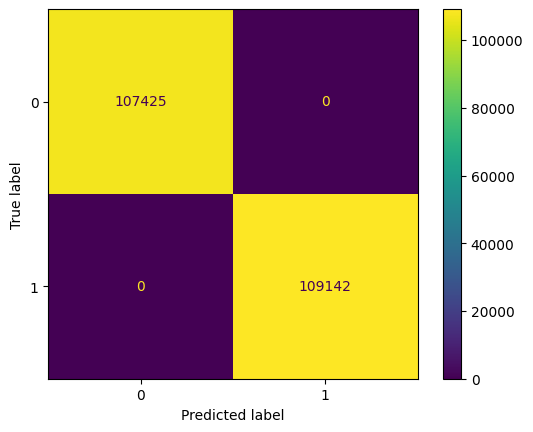

In [98]:
cm = confusion_matrix(y_train, y_train)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [99]:
X_test = Tensor(X_test)
y_test_pred = np.array([0 if (model(x).item() < 0.5) else 1 for x in X_test])

True Negative rate (specificity):  0.9671209413166518
True positive rate (recall):  0.03441325221725427
False Negative Rate:  0.9655867477827458
False positive rate:  0.03287905868334817
Positive Likelihood ratio:  0.03563973127870346


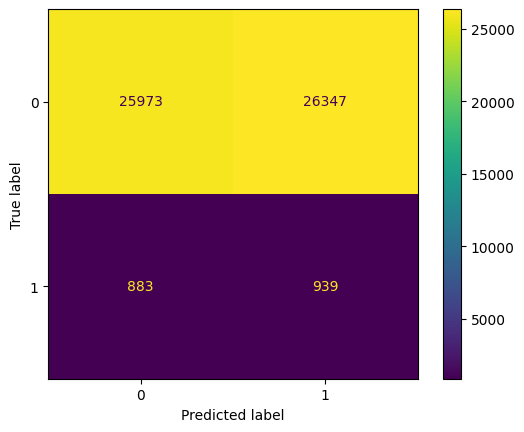

In [100]:
cm = confusion_matrix(y_test_pred, y_test)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)